In [121]:
# Imports
%matplotlib inline
import json
import numpy as np
from operator import itemgetter, attrgetter, methodcaller
import matplotlib.pyplot as plt
import re

In [122]:
# Paths
base_dir = "../.."
# results_file = base_dir + "/tmp/model_v4.3_data_testdlas96629/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_96629_10000.json"

# 4.3 dr5
    # False positive count: [1643], >20.3: [1628]
    # false negative count: [29], >20.3 [21]
    # mean col density diff: [-0.025777]
    # RMSE: [0.169069],
# results_file = base_dir + "/tmp/model_v4.3_data_dr5/predictions.json"
# gensample_actuals = base_dir + "/data/dr5_ground_truth.json"

# results_file = base_dir + "/tmp/model_v4.3_data_genmix23559/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_mix_23559_10000.json"

# results_file = base_dir + "/tmp/model_v5.1.0_data_dr5/predictions.json"
# gensample_actuals = base_dir + "/data/dr5_ground_truth.json"

# 5.1.0 dlas+slls - test mix
    # False positive count: [1712], >20.3: [144]
    # false negative count: [623], >20.3 [27]
    # mean col density diff: [0.057265]
    # RMSE: [0.209752]
# results_file = base_dir + "/tmp/model_v5.1.0_data_genmix23559/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_mix_23559_10000.json"

# 5.1.0 dlas+slls - test dla's 5k - 
    # False positive count: [1345], >20.3: [150]
    # false negative count: [54]
    # mean col density diff: [-0.057324]
    # RMSE: [0.174990]
# results_file = base_dir + "/tmp/model_v5.1.0_data_gendla96451/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_96451_5000.json"

# 4.4.1 dlas+slls - test dla's 5k
    # False positive count: [285], >20.3: [281]
    # false negative count: [74]
    # mean col density diff: [-0.008394]
    # RMSE: [0.141163]
# results_file = base_dir + "/tmp/model_v4.4.1_data_dlas5k96451/predictions.json"
# gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_96451_5000.json"

results_file = base_dir + "/tmp/model_v6.1.1_data_testdlas5k96451/predictions.json"
gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_96451_5000.json"

# results_file = base_dir + "/tmp/model_v6.1.1_data_dr5/predictions.json"
# gensample_actuals = base_dir + "/data/dr5_ground_truth.json"


In [123]:
# Read JSON files
with open(results_file,'r') as rf, open(gensample_actuals,'r') as gs:
    predictions = sorted(json.load(rf), key=itemgetter('id'))
    actuals = json.load(gs)

In [124]:
#
# Validation function that finds FP and FN in a single prediction and actual sightline.
#

EPSILON = 0.015   # Amount of error in the DLA Z value between prediction and actual, +-0.0037 ~= +-10px

def validate_sightline(prediction, actual):
    false_positives = []
    false_negatives = []
    col_density_error = []
    offset_error = []
    
    # Check each predicted DLA against all actual DLAs for false_positives and for col_density error
    for pred_dla in prediction['dlas']:
        dla_z = pred_dla['z_dla']
        matches = False
        for act_dla_ix in range(0, actual['nDLA']):
            act_dla = actual[str(act_dla_ix)]
            if abs(dla_z - act_dla['zabs']) < EPSILON:
                matches = True
                col_density_error.append((act_dla['NHI'], pred_dla['column_density'] - act_dla['NHI'], pred_dla['column_density'], act_dla['NHI'] - pred_dla['column_density']))
                offset_error.append((act_dla['NHI'], abs(pred_dla['z_dla']-act_dla['zabs'])))
        if not matches:
            false_positives.append(pred_dla)
        
    # Check each actual DLA against all predicted DLAs for false_negatives
    for act_dla_ix in range(0, actual['nDLA']):
        act_dla = actual[str(act_dla_ix)]
        matches = False
        for pred_dla in prediction['dlas']:
            dla_z = pred_dla['z_dla']
            if abs(dla_z - act_dla['zabs']) < EPSILON:
                matches = True
        if not matches:
            false_negatives.append(act_dla)

    return false_positives, false_negatives, col_density_error, offset_error

# ix = 5
# validate_sightline(results[ix], gensample[str(ix)])

# Count of False Positives, False Negatives and Column Density stats

In [125]:
# List misclassified results
all_false_positives = []
all_false_negatives = []
all_coldensity_diff = []
all_offset_error = []

for i in range(0,len(actuals)):
    fp, fn, cd, oe = validate_sightline(predictions[i], actuals[str(i)])
    all_offset_error.extend(oe)
    for f in fp:
        f['id'] = predictions[i]['id']
        f['z_qso'] = predictions[i]['z_qso']
    for f in fn:
        f['id'] = i
        f['sl'] = actuals[str(i)]['sl']
    all_false_positives.extend(fp)
    all_false_negatives.extend(fn)
    all_coldensity_diff.extend(cd)

all_coldensity_matrix = np.vstack(all_coldensity_diff)
mean_col_density = np.mean(all_coldensity_matrix[:,1])
rmse_col_density = np.sqrt(np.mean(np.array(all_coldensity_matrix[:,1])**2))
std_col_density = np.std(all_coldensity_matrix[:,1])

print "False positive count: [%d], >20.3: [%d]\nfalse negative count: [%d], >20.3 [%d]\nmean col density diff: [%02f]\nRMSE: [%02f],\nStd: [%02f]\n" %\
    (len(all_false_positives),
     len([fp for fp in all_false_positives if fp['column_density'] > 20.3]),
     len(all_false_negatives),
     len([fn for fn in all_false_negatives if fn['NHI'] >= 20.3]),
     mean_col_density, 
     rmse_col_density, 
     std_col_density)
    


False positive count: [1009], >20.3: [158]
false negative count: [52], >20.3 [52]
mean col density diff: [-0.045317]
RMSE: [0.161471],
Std: [0.154982]



# Plot column density error for all matching DLAs

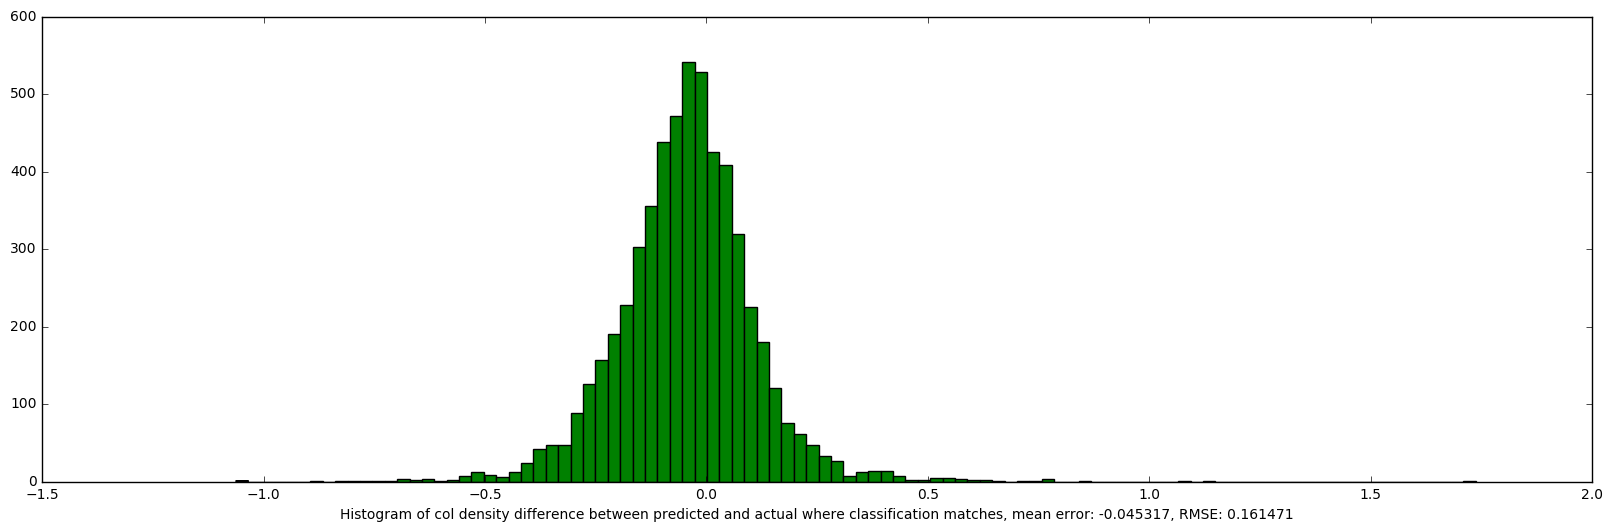

In [126]:
plt.figure(figsize=(20, 6))
plt.hist(all_coldensity_matrix[:,1], 100, facecolor='green');
plt.xlabel("Histogram of col density difference between predicted and actual where classification matches, " + \
           "mean error: %06f, RMSE: %06f" % (mean_col_density, rmse_col_density))

# Plot column density error for a range column densities

[19.2, 19.3] (0, 2) nan nan
[19.3, 19.4] (0, 2) nan nan
[19.4, 19.5] (0, 2) nan nan
[19.5, 19.6] (0, 2) nan nan
[19.6, 19.7] (0, 2) nan nan
[19.7, 19.8] (0, 2) nan nan
[19.8, 19.9] (2, 2) -0.55420049456 0.0683244956765
[19.9, 20.0] (12, 2) -0.414472956263 0.0719836954852
[20.0, 20.1] (41, 2) -0.310111695074 0.0845179840369
[20.1, 20.2] (93, 2) -0.209871166272 0.0685303058573
[20.2, 20.3] (214, 2) -0.135061531671 0.0924052522221
[20.3, 20.4] (516, 2) -0.0654993653528 0.0957070074363
[20.4, 20.5] (892, 2) -0.0218527926236 0.118253104222
[20.5, 20.6] (917, 2) -0.0298921357324 0.149385245812
[20.6, 20.7] (671, 2) -0.0268864517002 0.154276261566
[20.7, 20.8] (555, 2) -0.0426412724095 0.158368413277
[20.8, 20.9] (461, 2) -0.0423729570717 0.167739169917
[20.9, 21.2] (824, 2) -0.040097653535 0.164089901444
[21.2, 21.5] (354, 2) -0.0363239861732 0.189627252958
[21.5, 21.8] (87, 2) -0.0407646643476 0.168708924875
[21.8, 22.4] (15, 2) 0.158931949082 0.526381666493
[ -7.630933354116763156493874475

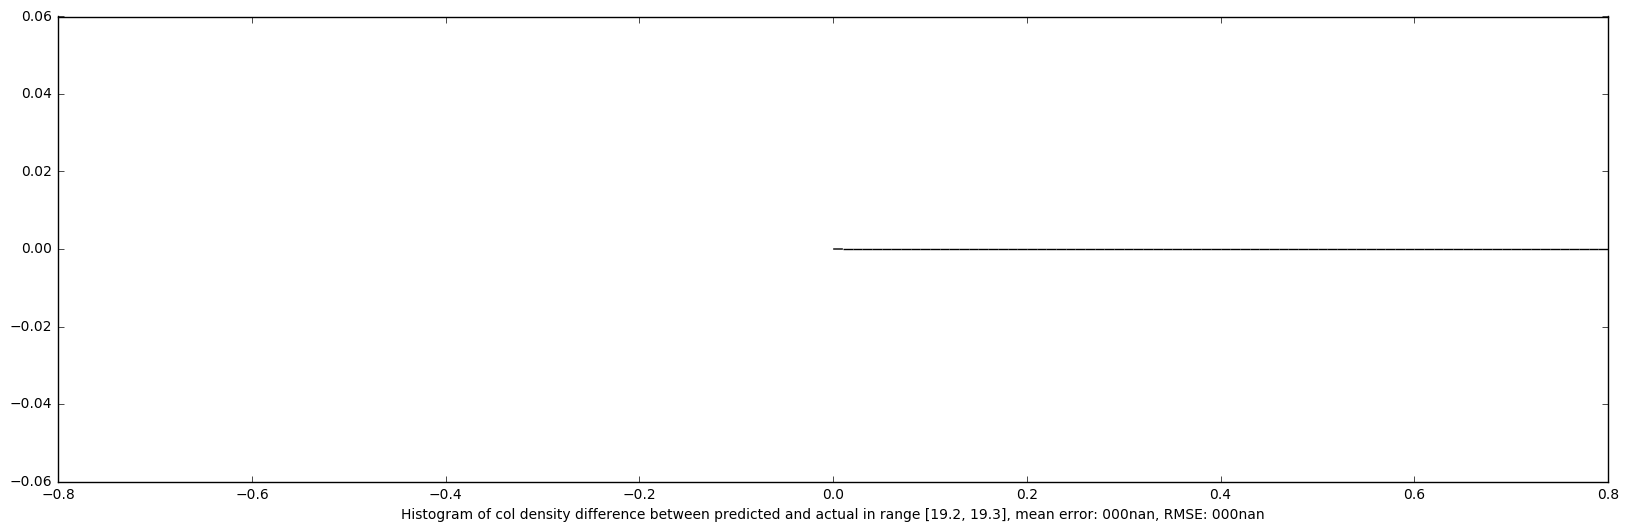

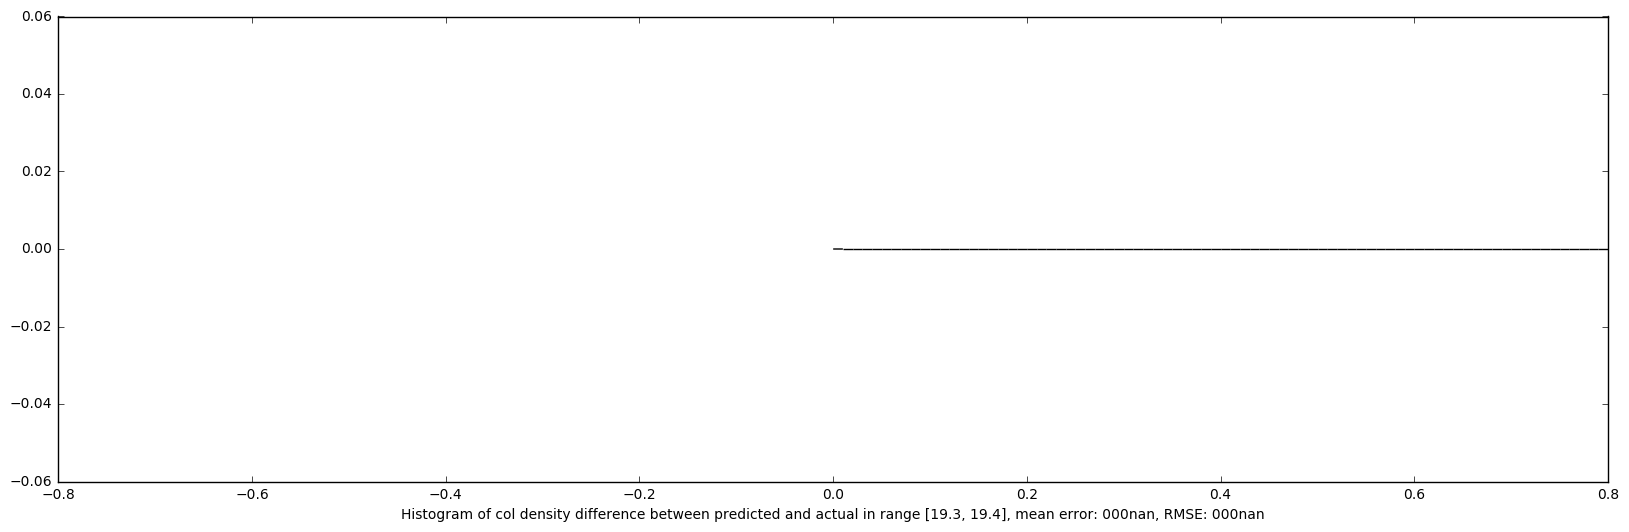

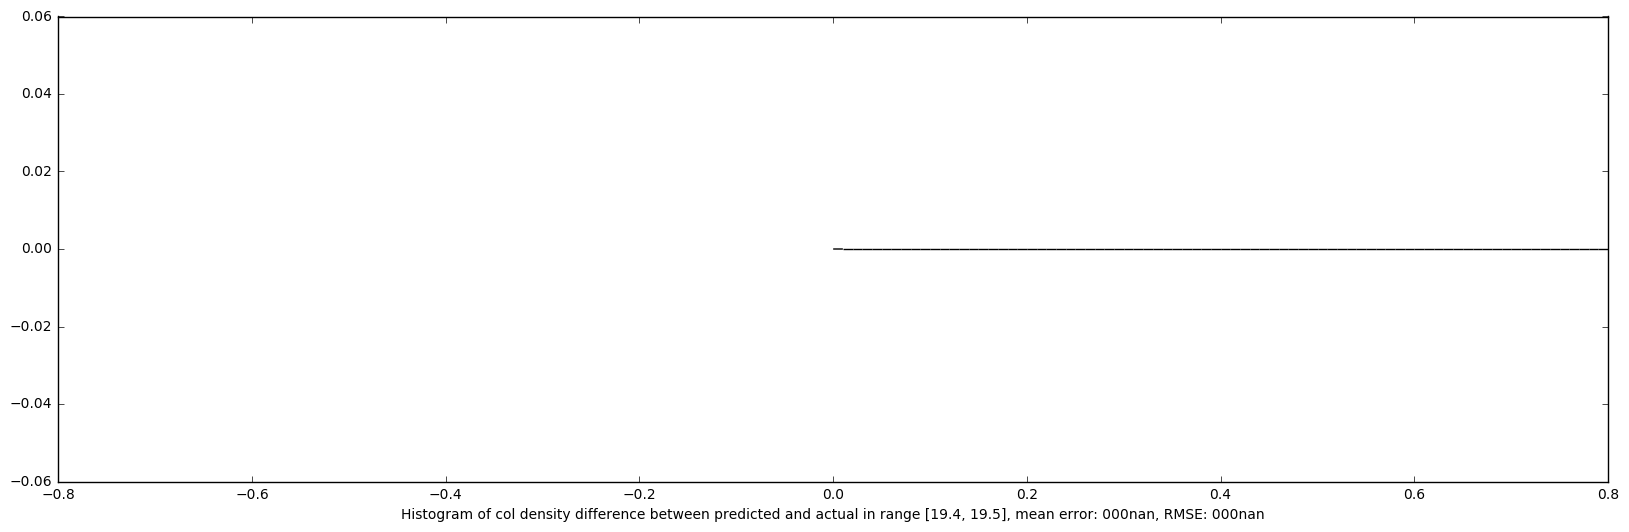

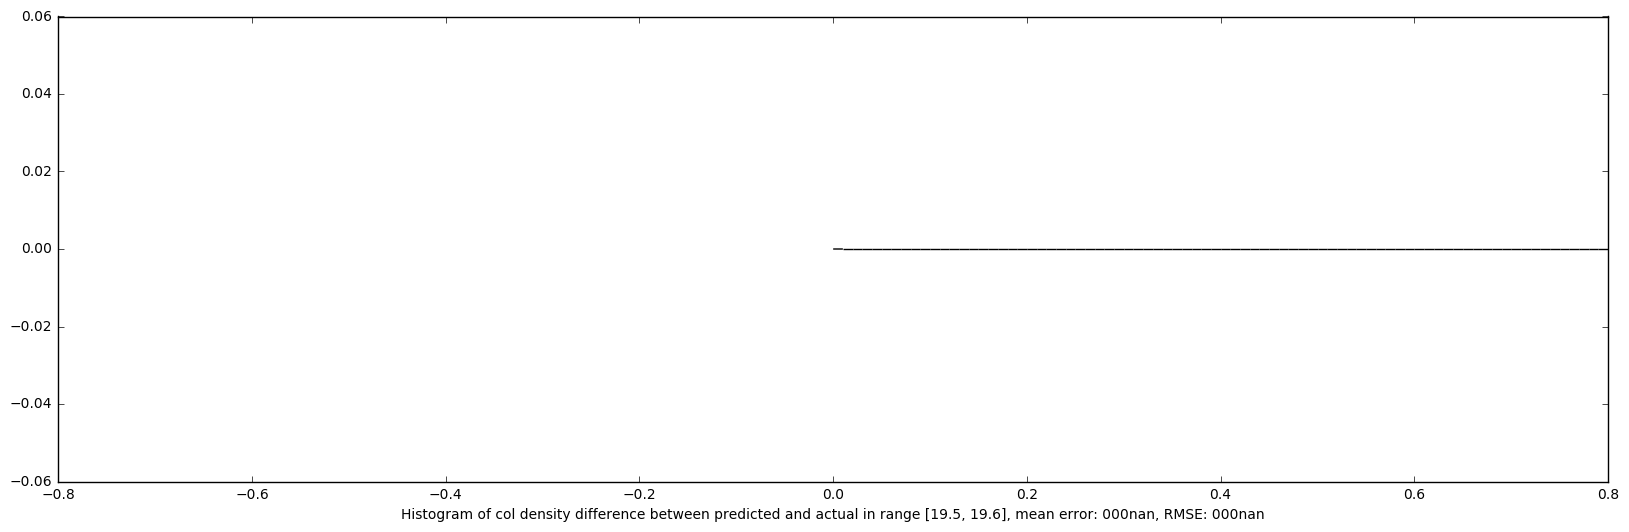

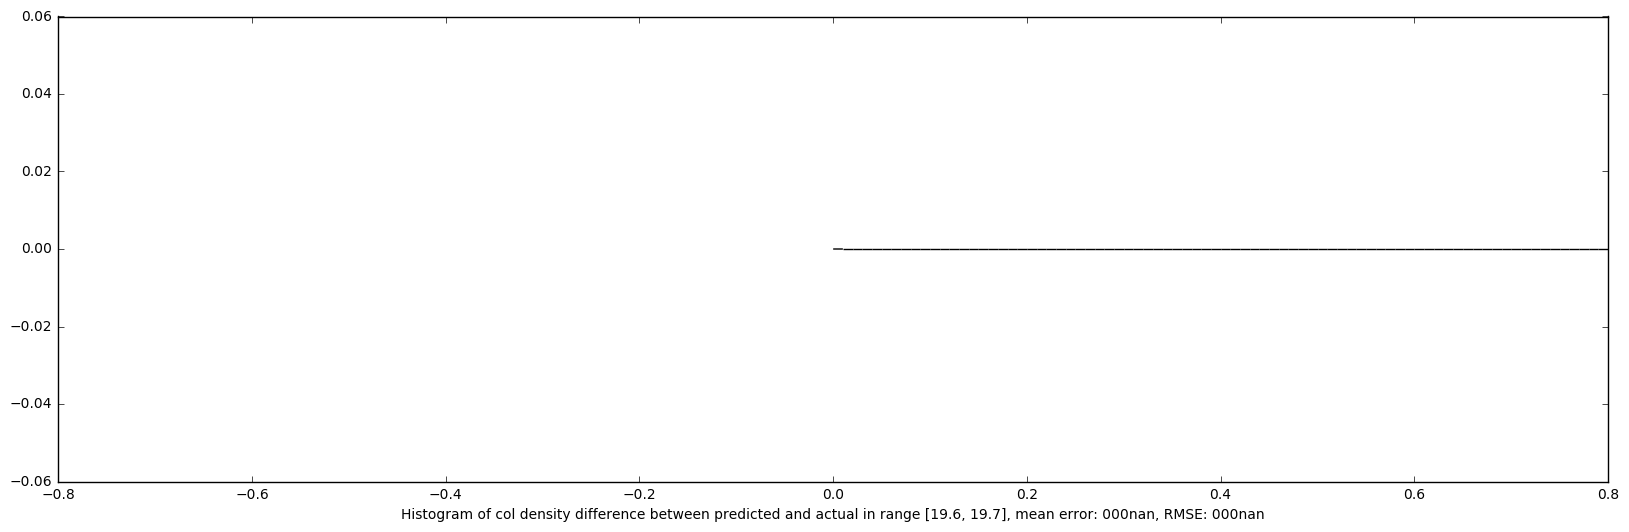

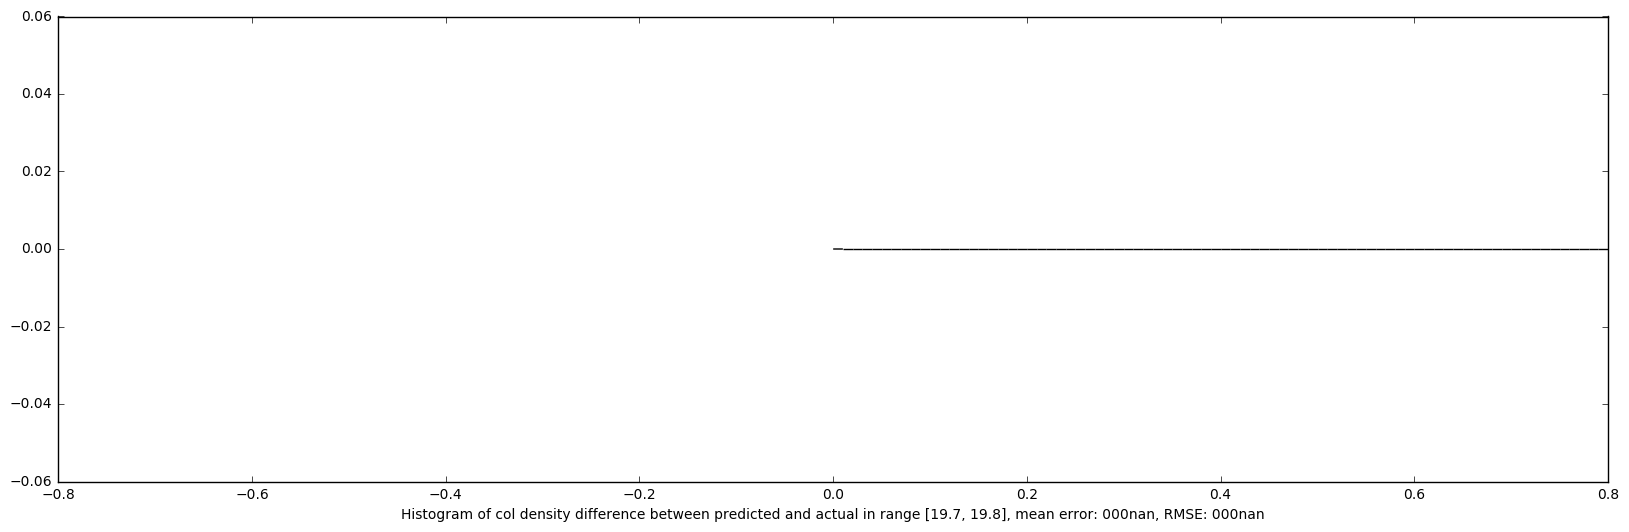

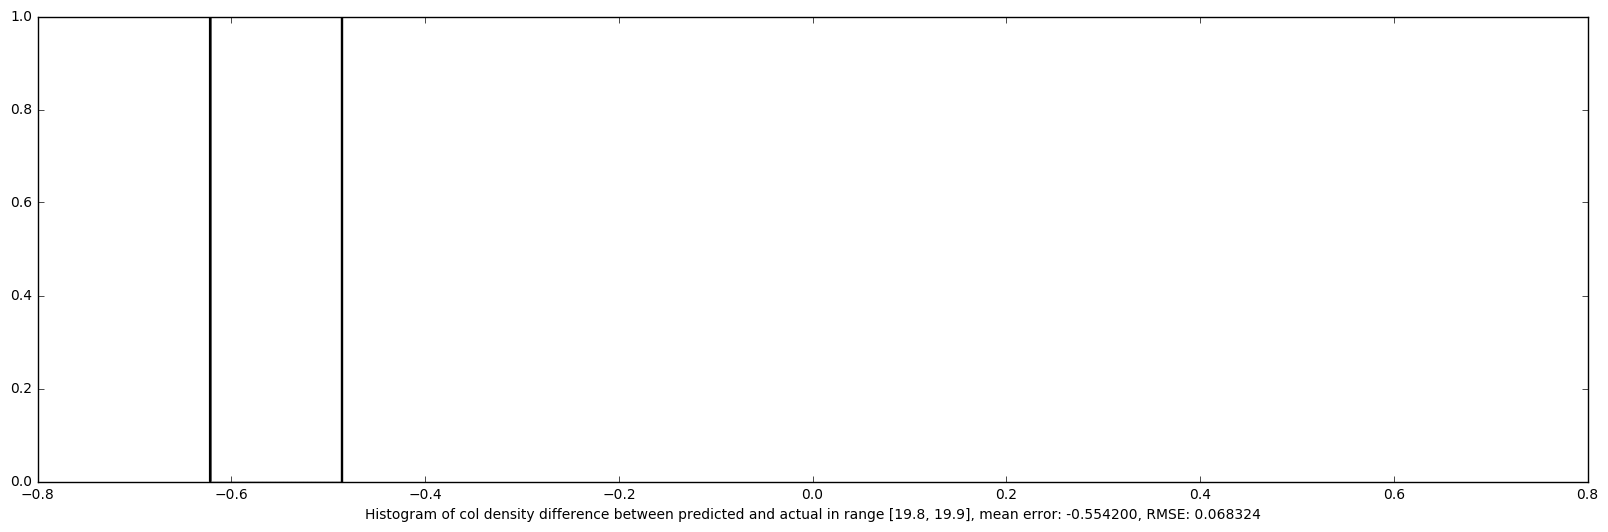

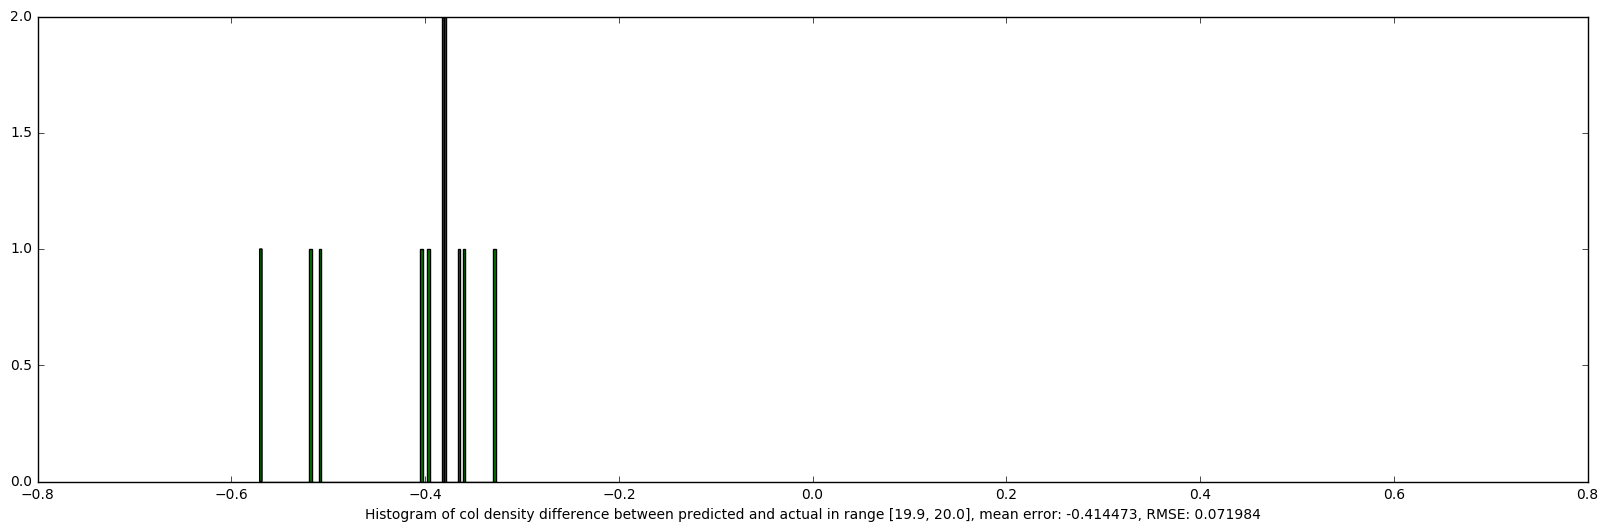

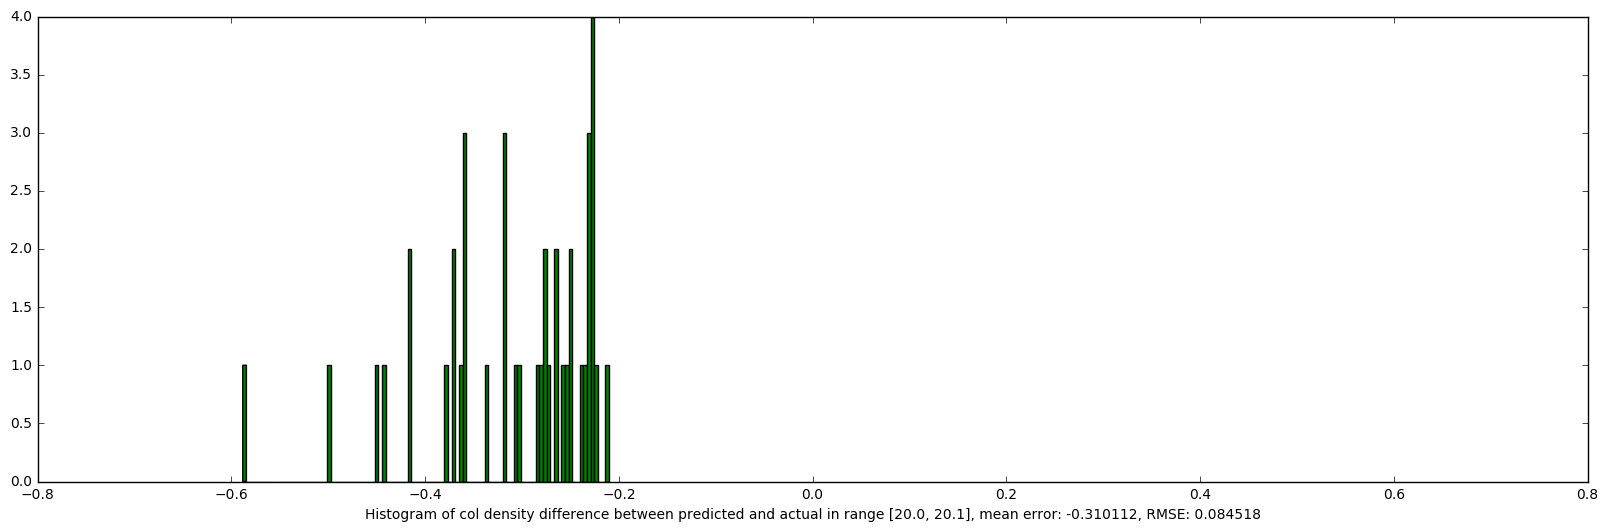

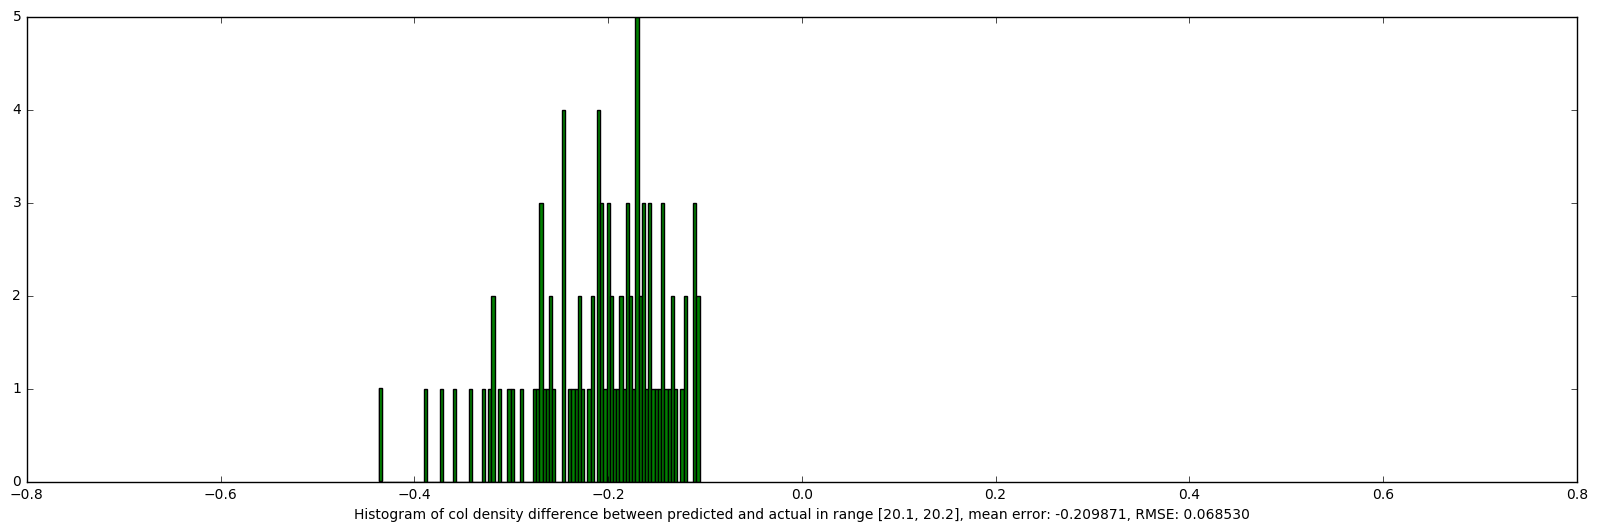

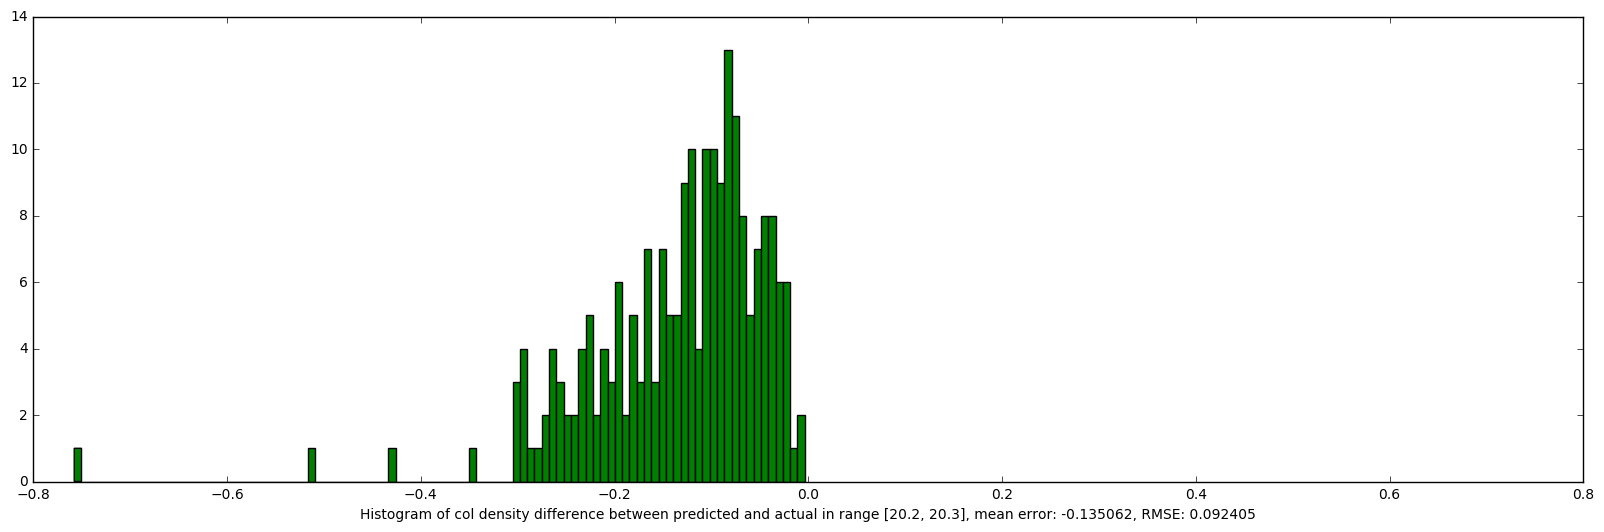

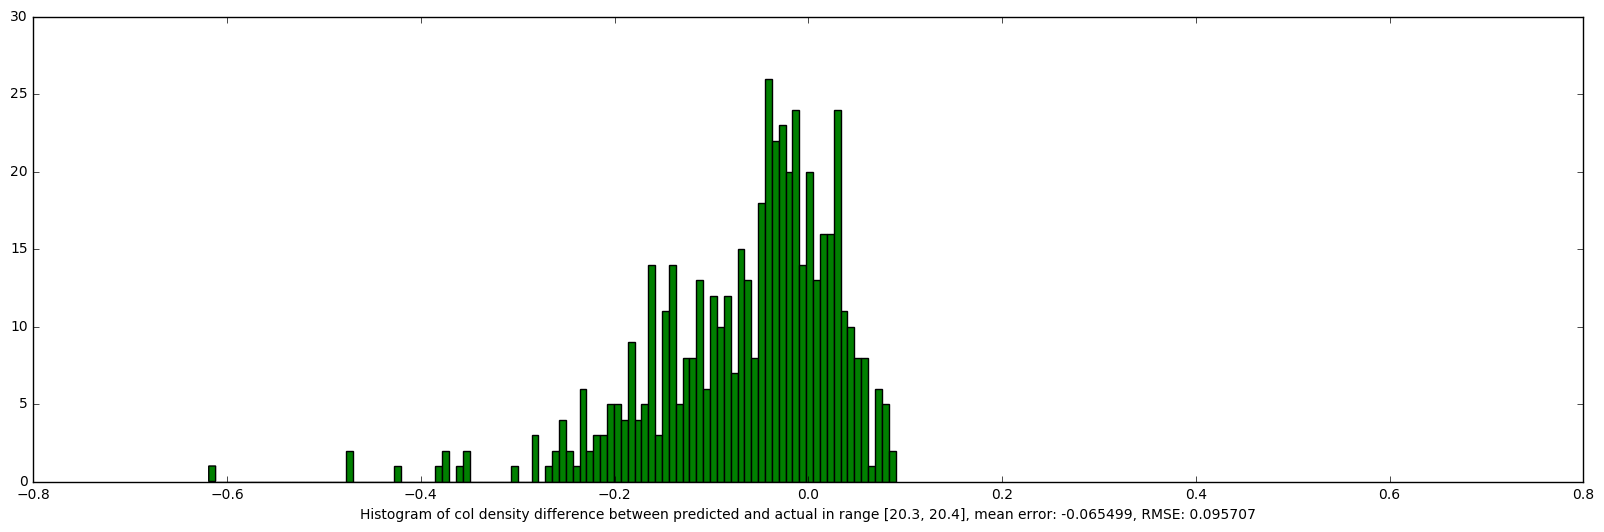

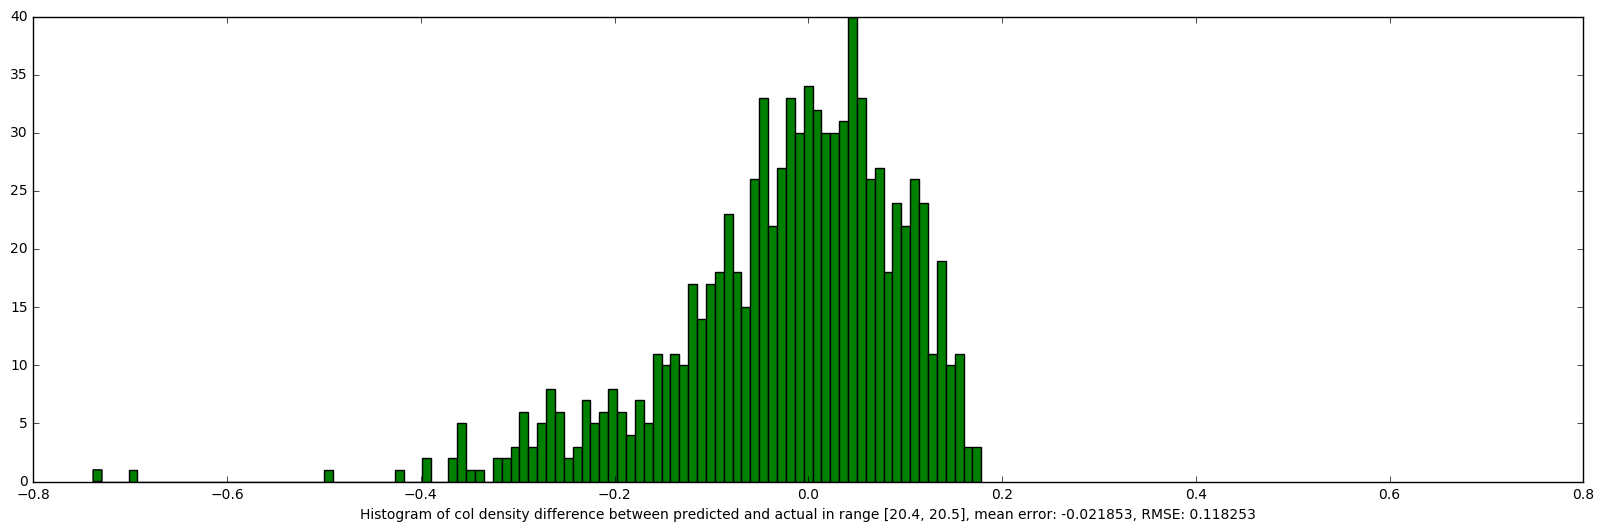

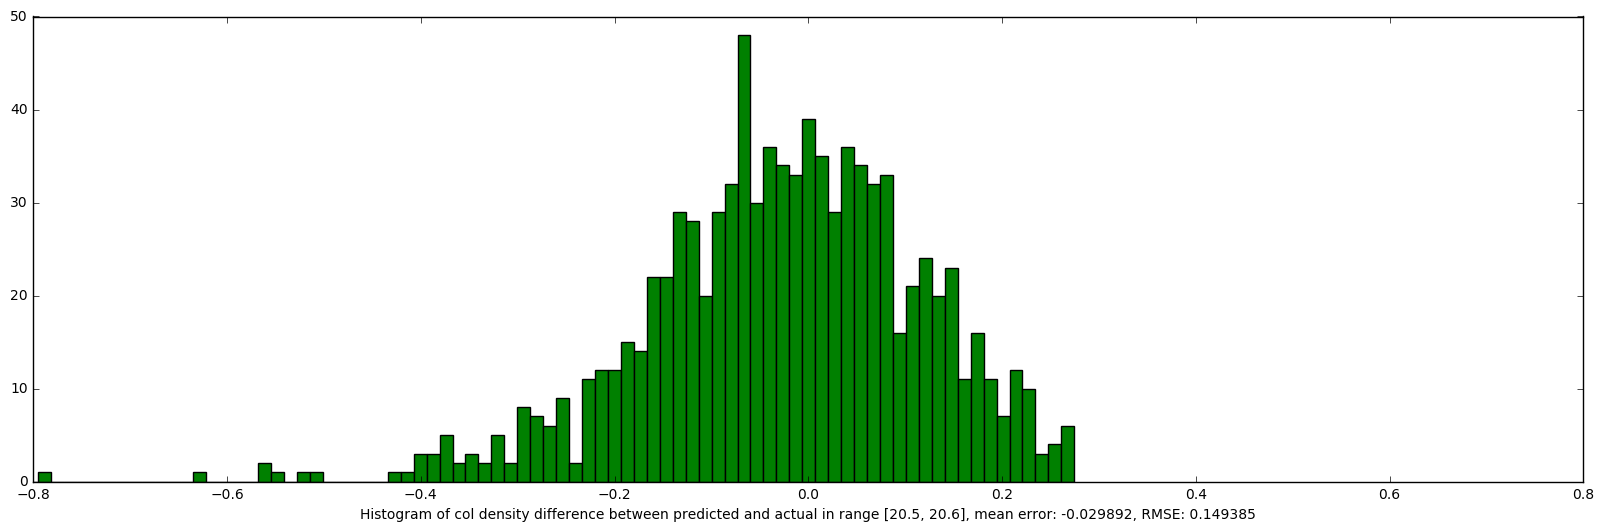

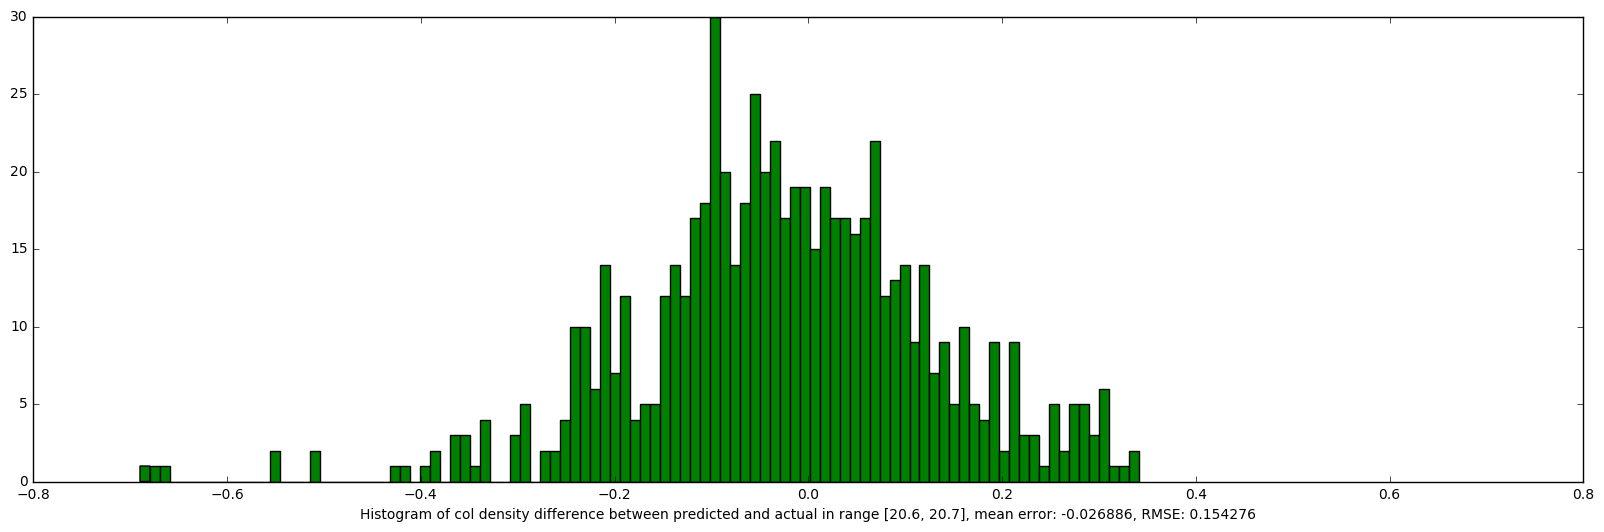

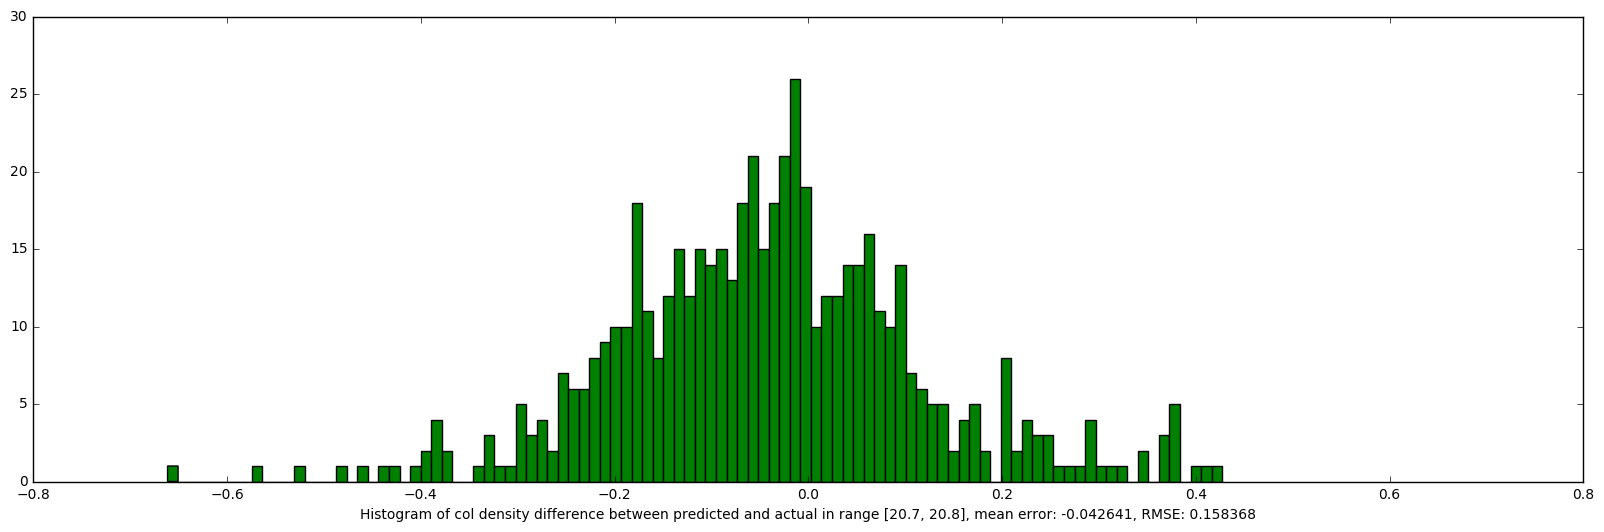

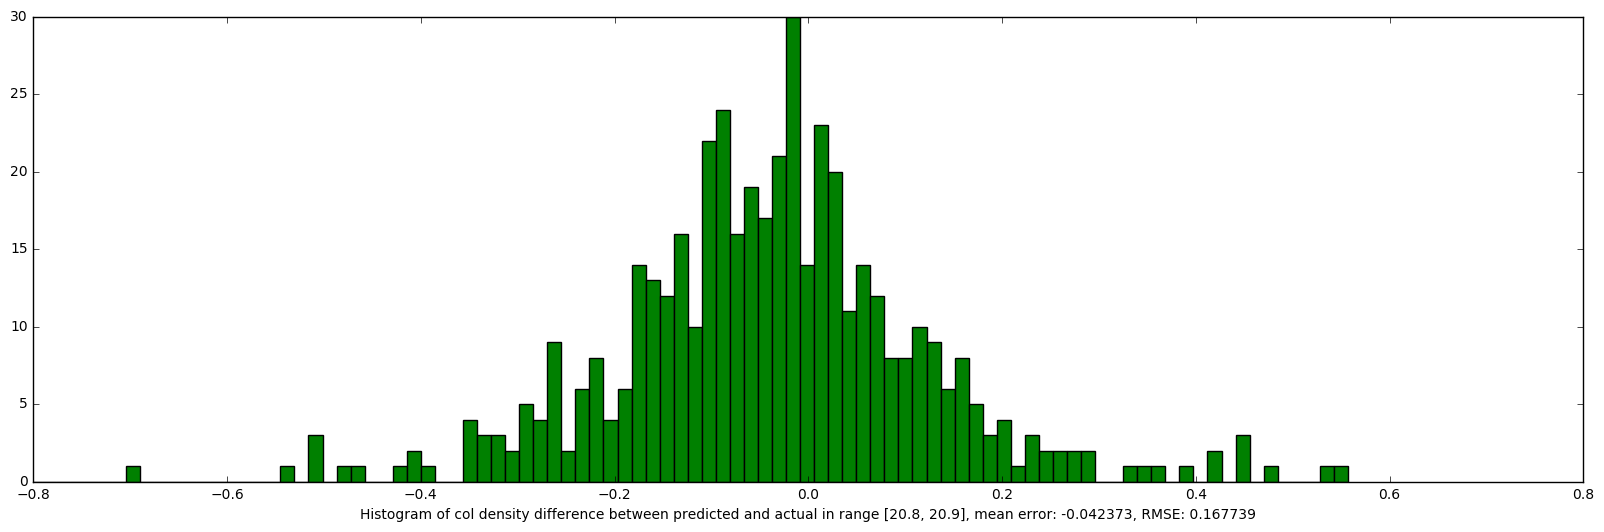

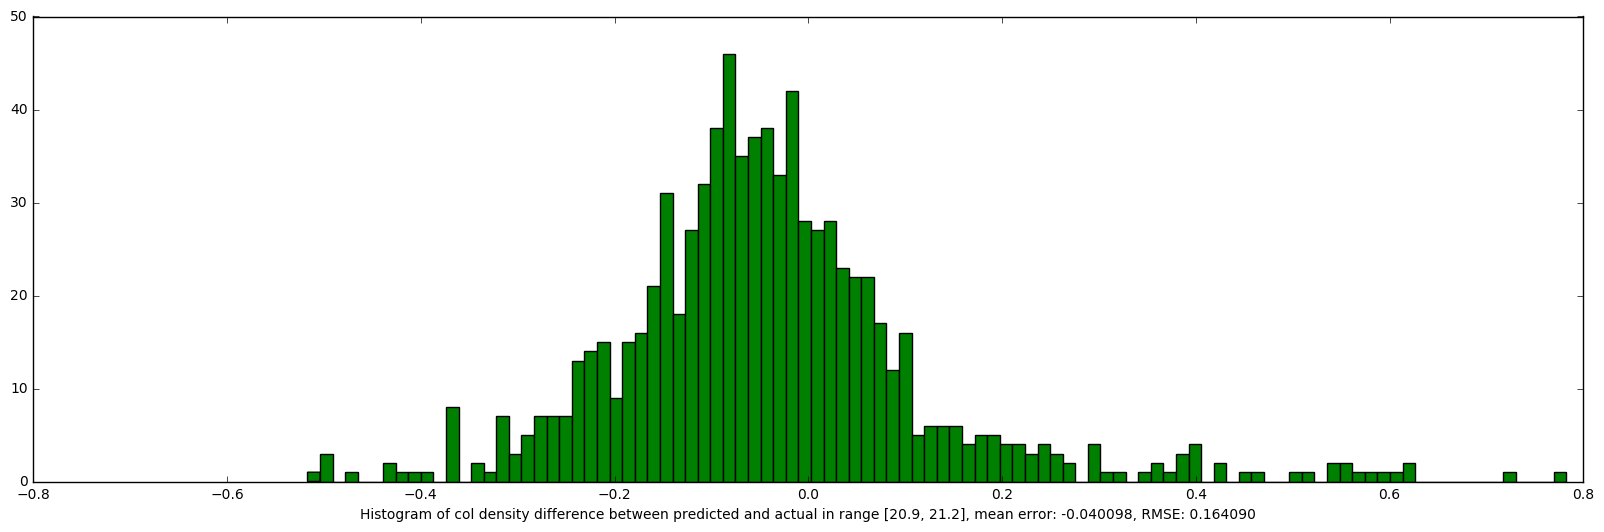

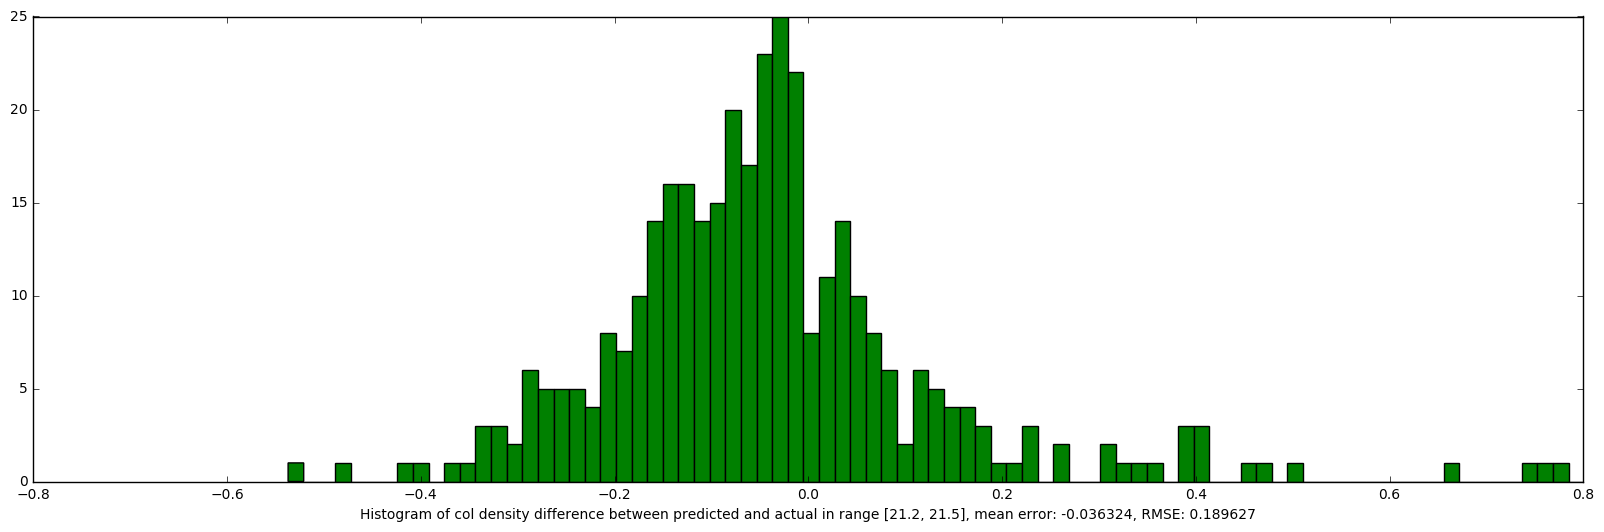

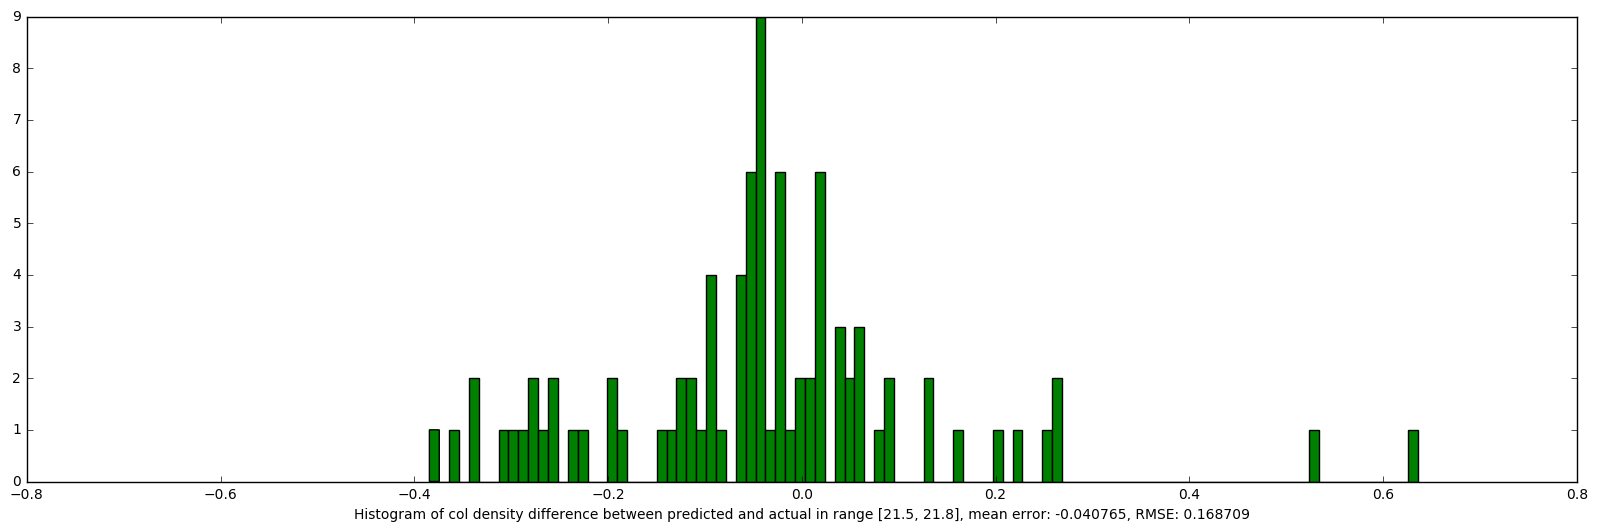

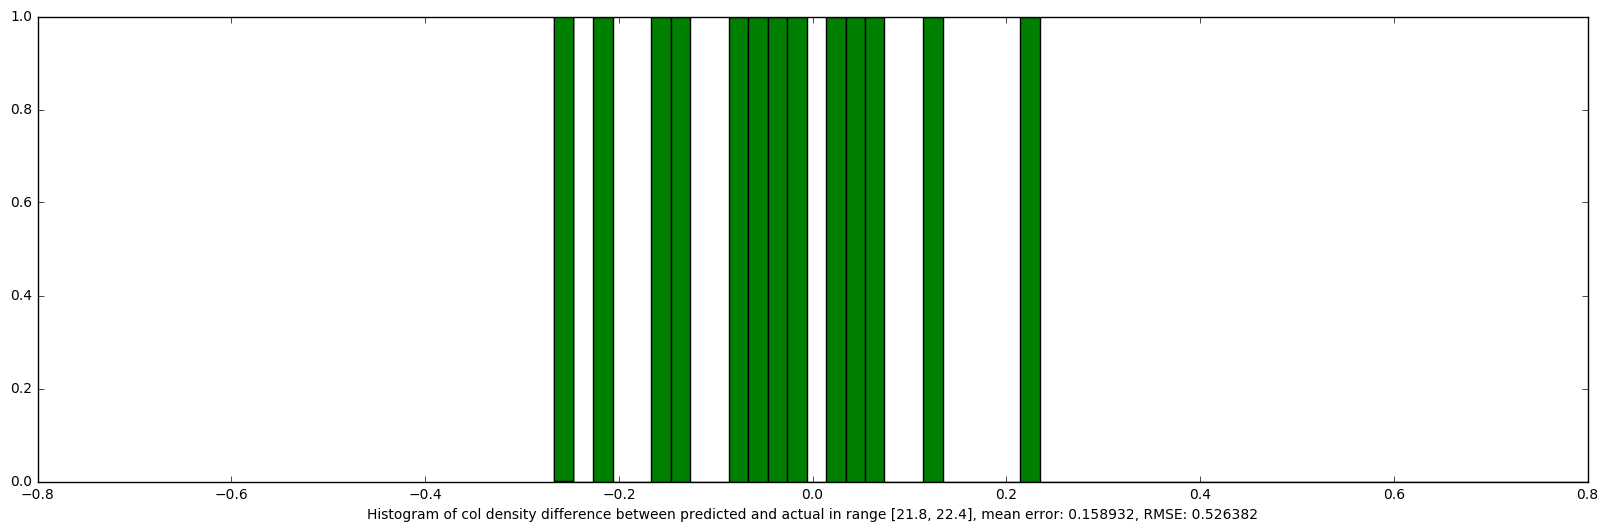

In [127]:
for crange in [[19.2,19.3],
               [19.3,19.4],
               [19.4,19.5],
               [19.5,19.6],
               [19.6,19.7],
               [19.7,19.8],
               [19.8,19.9],
               [19.9,20.0],
               [20.0,20.1],
               [20.1,20.2],
               [20.2,20.3],
               [20.3,20.4],
               [20.4,20.5],
               [20.5,20.6],
               [20.6,20.7],
               [20.7,20.8],
               [20.8,20.9],
               [20.9,21.2],
               [21.2,21.5],
               [21.5,21.8],
               [21.8,22.4]]:
    inrange_coldensity_matrix = all_coldensity_matrix[(all_coldensity_matrix[:,2]>=crange[0])& \
                                                       (all_coldensity_matrix[:,2]<crange[1]),0:2]
    plt.figure(figsize=(20, 6))
    plt.hist(inrange_coldensity_matrix[:,1], 100, facecolor='green');
    plt.xlabel(
        "Histogram of col density difference between predicted and actual in range %s, mean error: %06f, RMSE: %06f" \
        % (str(crange), np.mean(inrange_coldensity_matrix[:,1]), np.std(inrange_coldensity_matrix[:,1])))
    plt.xlim([-0.8,0.8])
    print crange, inrange_coldensity_matrix.shape, \
            np.mean(inrange_coldensity_matrix[:,1]), \
            np.std(inrange_coldensity_matrix[:,1])
  
# print full_coldensity_matrix[0:3,:]
np.set_printoptions(precision=30)
print np.polyfit(all_coldensity_matrix[:,0], all_coldensity_matrix[:,1], 3)
with open('data.txt', 'w') as outfile:
    np.savetxt(outfile, all_coldensity_matrix)
    #json.dump(full_coldensity_matrix[:,0:2].tolist(), outfile, indent=4)


# Plot dz vs column density actual (all matching samples)

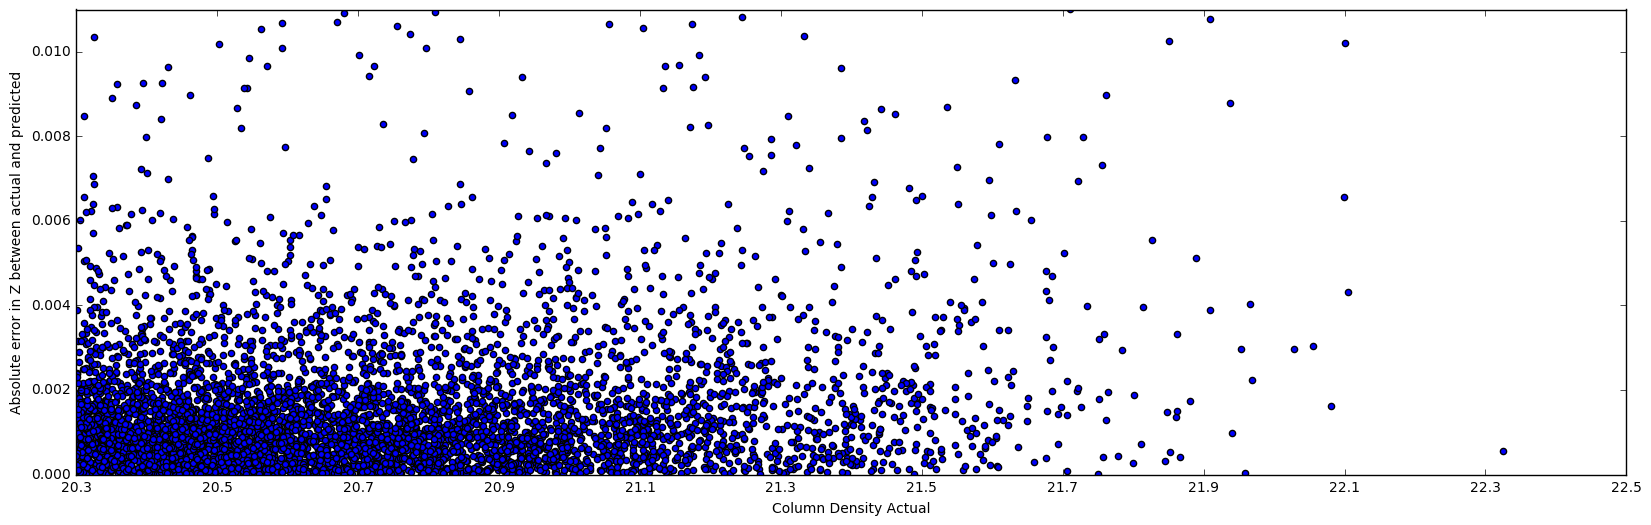

In [128]:
p = np.vstack(all_offset_error)
plt.figure(figsize=(20, 6))
plt.scatter(p[:,0], p[:,1])
plt.xlim([20.3,22.5])
plt.ylim([0,0.011])
plt.xticks([20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Column Density Actual")
plt.ylabel("Absolute error in Z between actual and predicted")

# Plot column density error vs actual column density (all matching samples)
#Plot 1: X axis: actual column density, Y axis: error from actual
#Plot 2: X axis: predicted column density, Y axis: error from actual

[ -7.630933354116763156493874475927e-02
   4.882892915642116804519901052117e+00
  -1.042382798165982791260830708779e+02
   7.422534137521929551439825445414e+02]


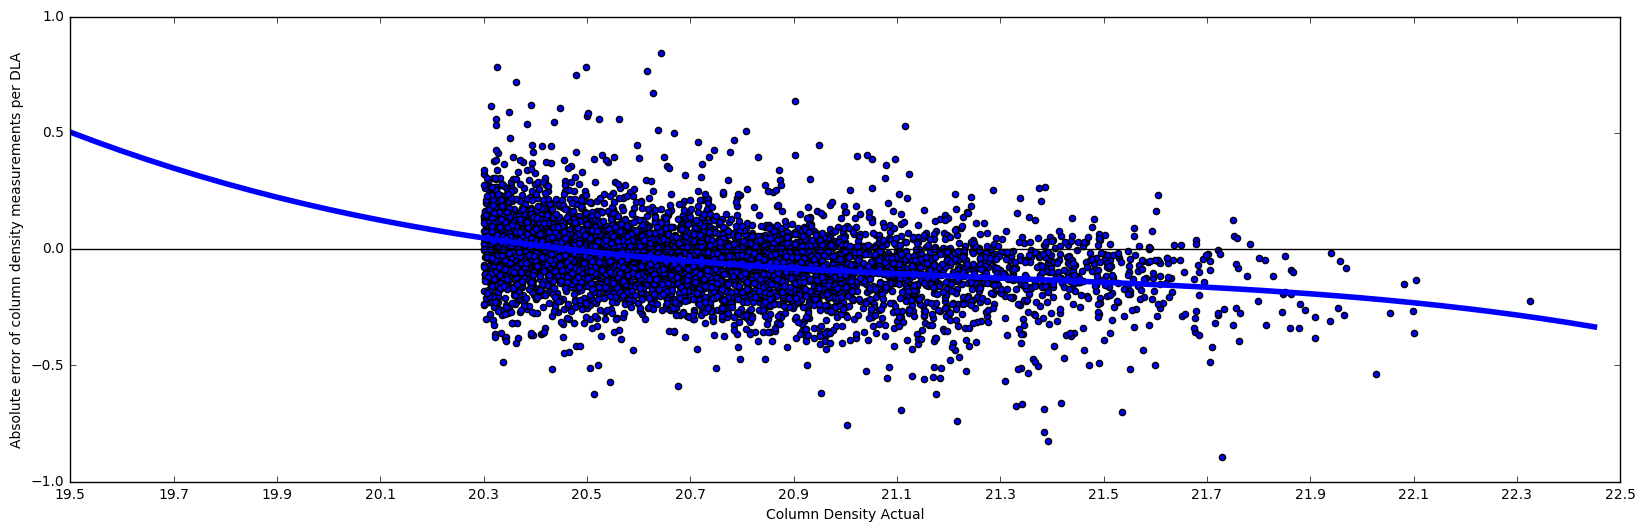

In [129]:
x = all_coldensity_matrix[:,0]
y = all_coldensity_matrix[:,1]

poly_range = np.arange(19.5,22.5,0.05)
poly = np.polyfit(x, y, 3)

plt.figure(figsize=(20, 6))
plt.scatter(x, y)  # 0,1-per actual, 2,3-per predicted
plt.xlim([20.3,22.5])
plt.ylim([-1.0,1.0])
plt.xticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Column Density Actual")
plt.ylabel("Absolute error of column density measurements per DLA")
plt.axhline(color="black")

plt.plot(poly_range, np.polyval(poly, poly_range), '-', linewidth=4)
print poly

[  4.399747339879599983269997665047e-01
  -2.768737426126544320936773146968e+01
   5.806654104634922077821101993322e+02
  -4.058492513442436575132887810469e+03]


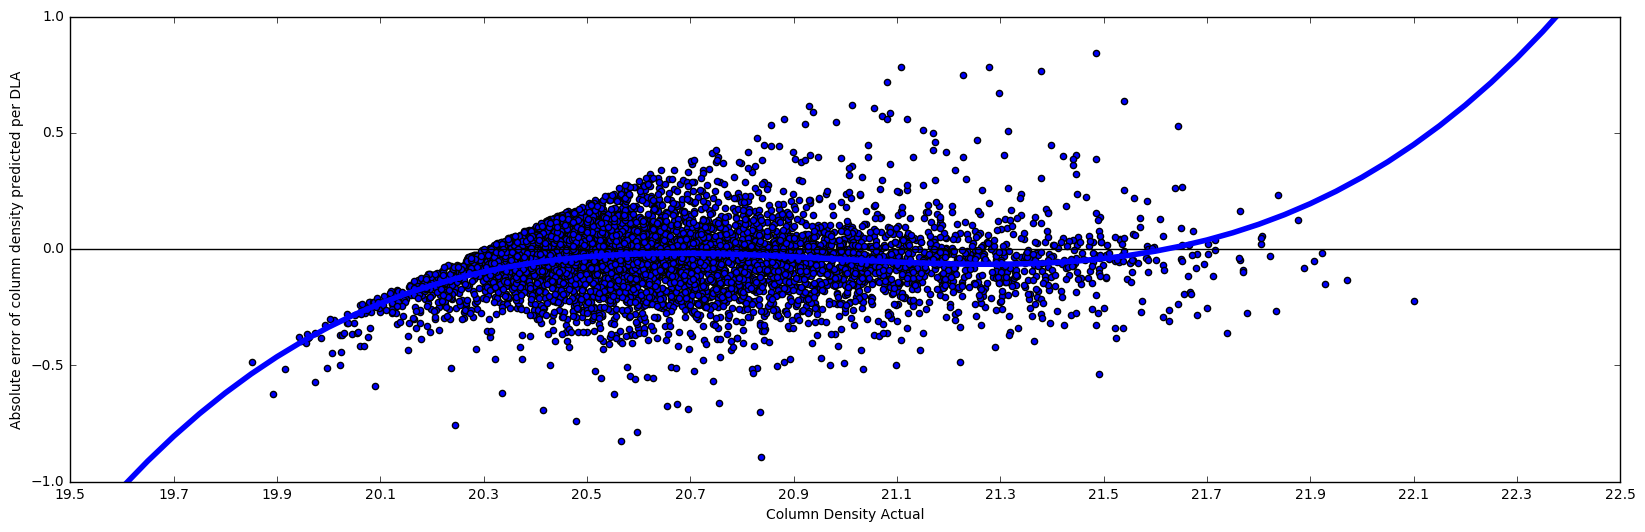

In [130]:
x = all_coldensity_matrix[:,2]
y = all_coldensity_matrix[:,1]

poly_range = np.arange(19.5,22.5,0.05)
poly = np.polyfit(x, y, 3)

plt.figure(figsize=(20, 6))
plt.scatter(x, y)  # 0,1-per actual, 2,3-per predicted
plt.xlim([20.3,22.5])
plt.ylim([-1.0,1.0])
plt.xticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Column Density Actual")
plt.ylabel("Absolute error of column density predicted per DLA")
plt.axhline(color="black")

plt.plot(poly_range, np.polyval(poly, poly_range), '-', linewidth=4)
print poly

# Predicted col density vs. Actual
Matching samples based on redshift

[ 0.943293213932980822988838554011  1.218488843253381359588161103602]


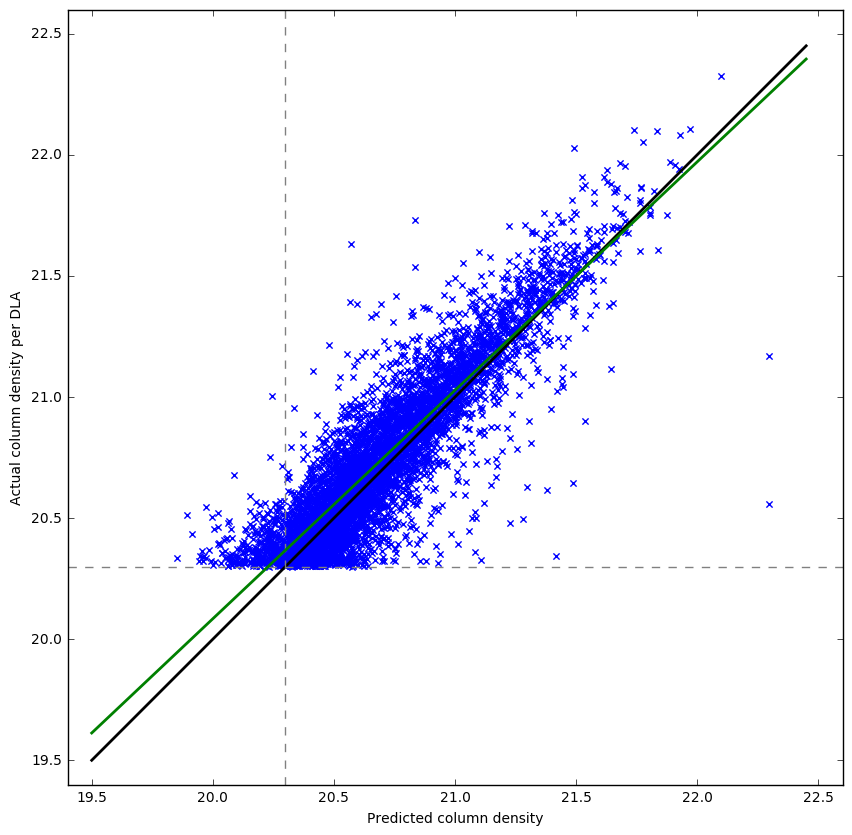

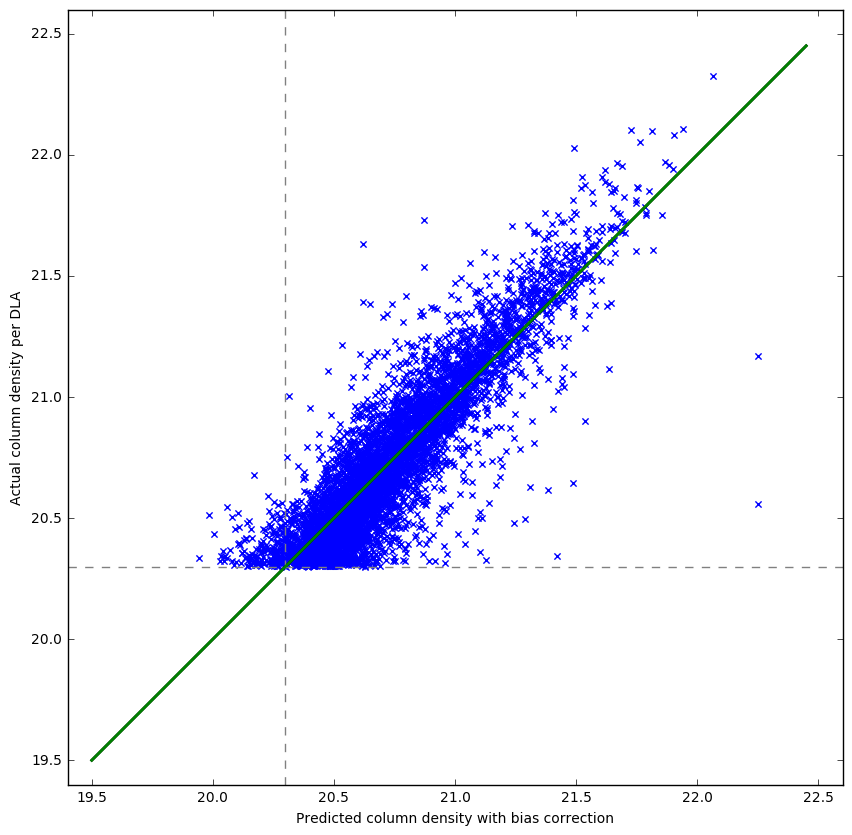

In [131]:
degree = 1

# Predicted X, actual Y
x = all_coldensity_matrix[:,2]
y = all_coldensity_matrix[:,0]
r = np.arange(19.5,22.5,0.05)

plt.figure(figsize=(10, 10))
plt.scatter(x, y, marker="x")  # 0,1-per actual, 2,3-per predicted
plt.xlim([19.4,22.6])
plt.ylim([19.4,22.6])
plt.xlabel("Predicted column density")
plt.ylabel("Actual column density per DLA")
plt.plot(r, r, linewidth=2, color='black')
plt.axvline(20.3, linestyle='--', color='gray')
plt.axhline(20.3, linestyle='--', color='gray')

# Polyfit
p = np.polyfit(x,y,degree)
plt.plot(r, np.polyval(p,r), linewidth=2, color='green')
print p

# Bias correction
x_bias_corrected = np.polyval(p, x)

plt.figure(figsize=(10, 10))
plt.scatter(x_bias_corrected, y, marker="x")  # 0,1-per actual, 2,3-per predicted
plt.xlim([19.4,22.6])
plt.ylim([19.4,22.6])
plt.xlabel("Predicted column density with bias correction")
plt.ylabel("Actual column density per DLA")
plt.plot(r, r, linewidth=2, color='black')
plt.axvline(20.3, linestyle='--', color='gray')
plt.axhline(20.3, linestyle='--', color='gray')

p = np.polyfit(x_bias_corrected,y,degree)
plt.plot(r, np.polyval(p,r), linewidth=2, color='green')


# Histogram of where False Positives >20.3 are found on the spectrum

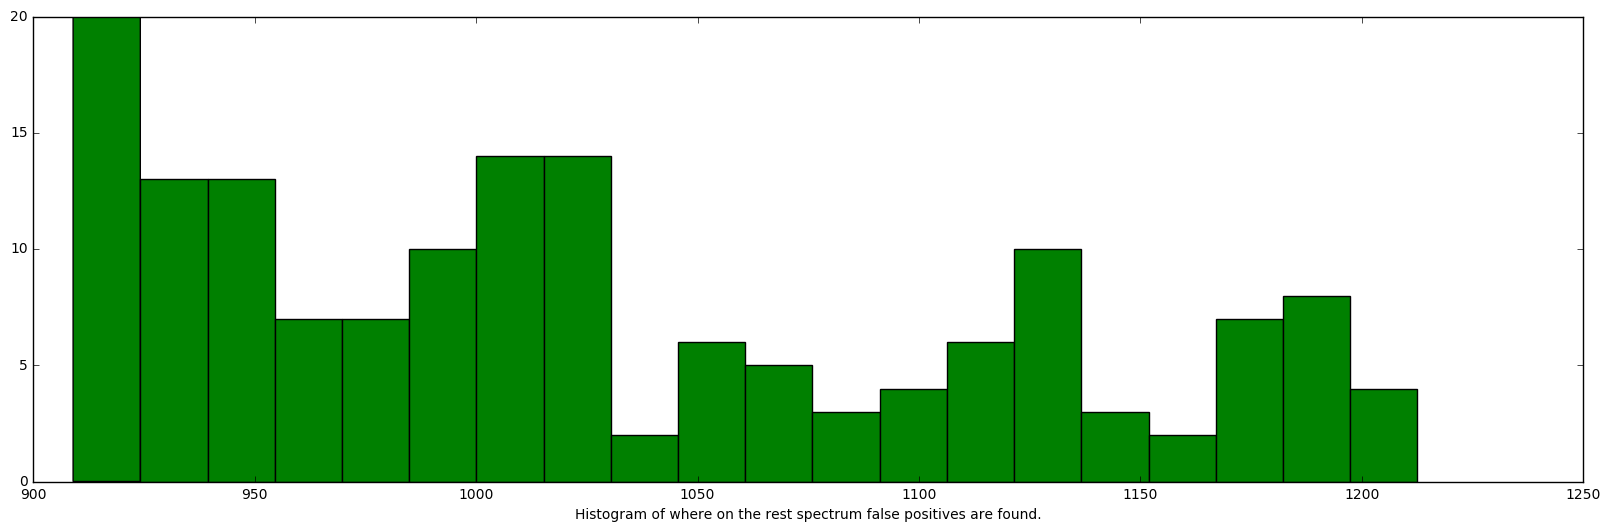

In [132]:
rest_frame_fps = [fp['rest'] for fp in all_false_positives if fp['column_density'] > 20.3]
plt.figure(figsize=(20, 6))
plt.hist(rest_frame_fps, 20, facecolor='green');
plt.xlabel("Histogram of where on the rest spectrum false positives are found.")

# Scatter plot of where False Positives are found on the spectrum

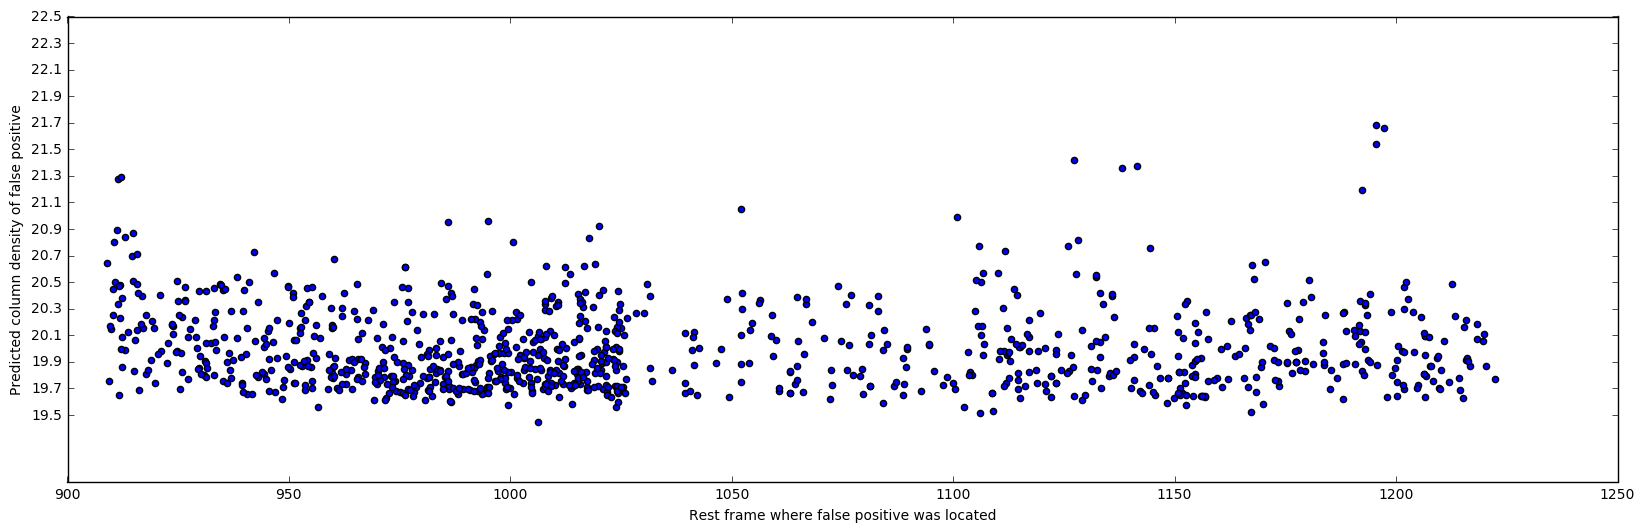

In [133]:
rest_frame_fps = [fp['rest'] for fp in all_false_positives]
col_density_fps = [fp['column_density'] for fp in all_false_positives]

plt.figure(figsize=(20, 6))
plt.scatter(rest_frame_fps, col_density_fps)
plt.xlim([900,1250])
plt.yticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Rest frame where false positive was located")
plt.ylabel("Predicted column density of false positive")

# False positives histogram by column density

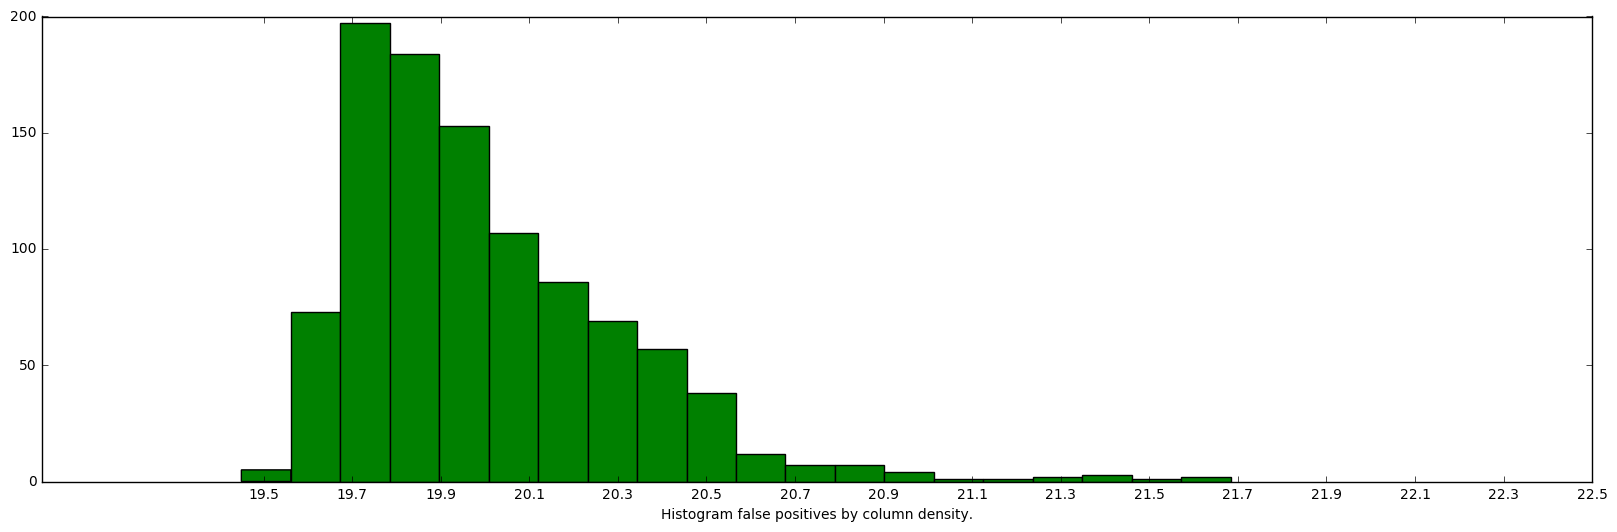

In [134]:
col_density_fps = [fp['column_density'] for fp in all_false_positives]
plt.figure(figsize=(20, 6))
plt.hist(col_density_fps, 20, facecolor='green');
plt.xlabel("Histogram false positives by column density.")
plt.xticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5]);

# TODO (as above)
# False negatives histogram by column density 

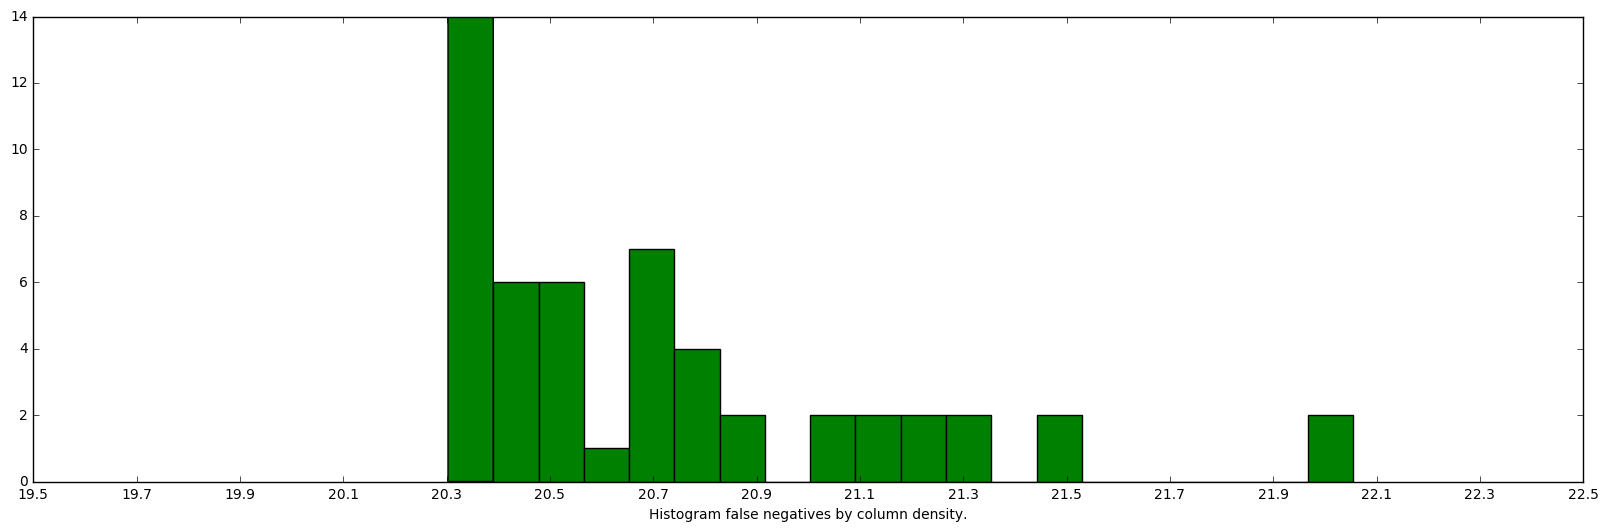

In [135]:
col_density_fps = [fn['NHI'] for fn in all_false_negatives]
plt.figure(figsize=(20, 6))
plt.hist(col_density_fps, 20, facecolor='green');
plt.xlabel("Histogram false negatives by column density.")
plt.xticks([19.5,19.7,19.9,20.1,20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5]);

# Confidence for False Positives vs confidence of correct DLAs

(0, 80)

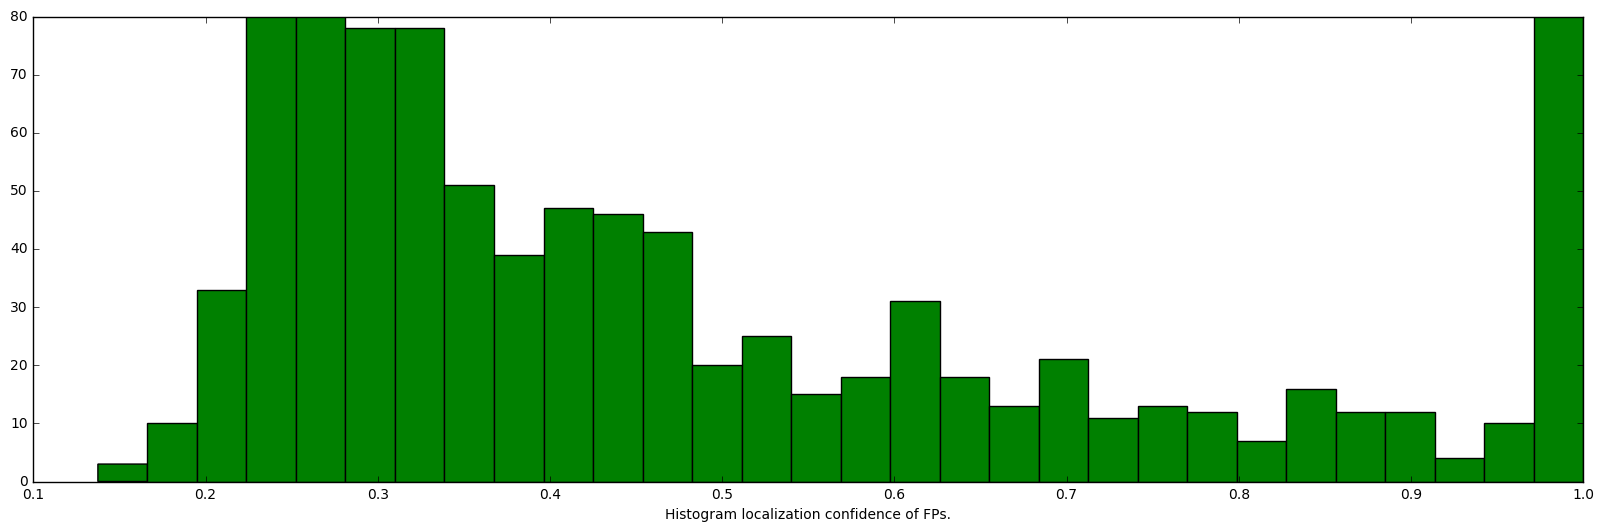

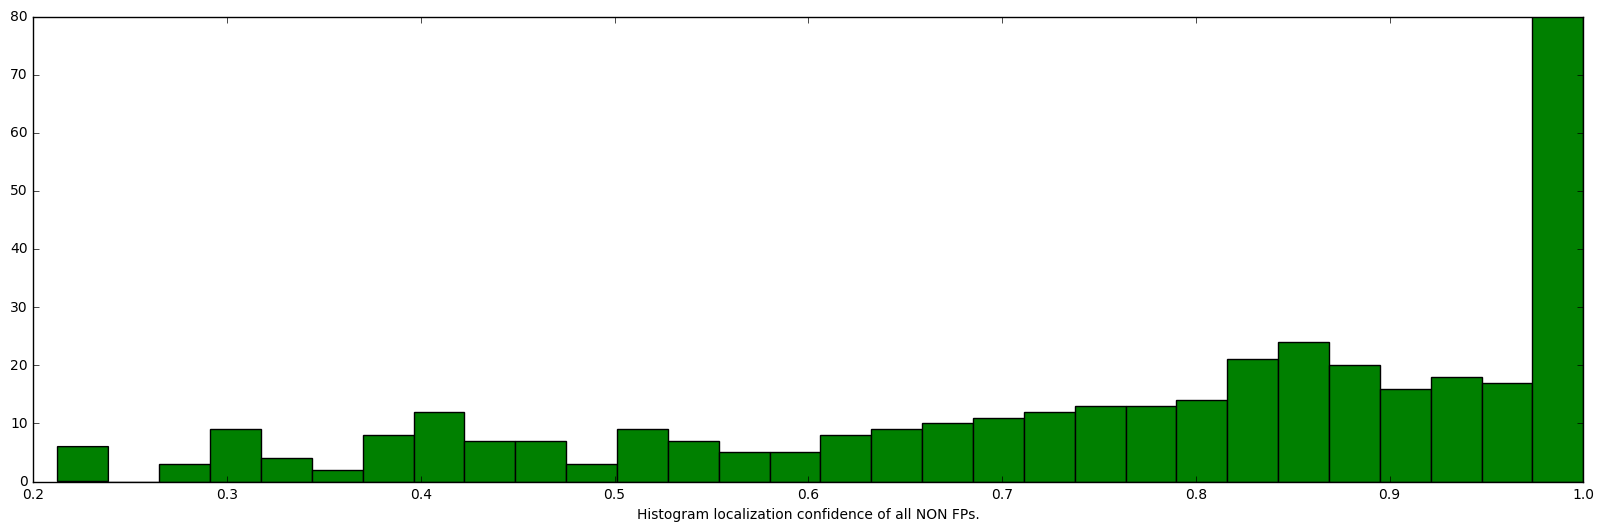

In [136]:
fps_dla_conf = [dla['dla_confidence'] for dla in all_false_positives]
fps_dla_ids = [dla['id'] for dla in all_false_positives]
all_nonfps_dlas = [psub for p in predictions if p['id'] not in fps_dla_ids for psub in p['dlas']]
all_nonfps_conf = [d['dla_confidence'] for d in all_nonfps_dlas]

plt.figure(figsize=(20, 6))
plt.hist(fps_dla_conf, 30, facecolor='green');
plt.xlabel("Histogram localization confidence of FPs.")
plt.ylim([0,80])

plt.figure(figsize=(20, 6))
plt.hist(all_nonfps_conf, 30, facecolor='green');
plt.xlabel("Histogram localization confidence of all NON FPs.")
plt.ylim([0,80])


# Display False Positives list

In [137]:
print json.dumps(all_false_positives, indent=1)

[
 {
  "std_column_density": 0.08826751261949539, 
  "column_density": 20.060455322265625, 
  "spectrum": 4897.788193684466, 
  "rest": 1064.9833771765873, 
  "column_density_bias_adjust": 0.0, 
  "dla_confidence": 0.8625, 
  "z_qso": 3.5989339351654053, 
  "id": "test_dlas_96451_5000_ix_0001", 
  "z_dla": 3.028879707226851
 }, 
 {
  "std_column_density": 0.08917094022035599, 
  "column_density": 20.12497901916504, 
  "spectrum": 4210.173564456214, 
  "rest": 913.6034974607657, 
  "column_density_bias_adjust": 0.0, 
  "dla_confidence": 0.42500000000000004, 
  "z_qso": 3.608315944671631, 
  "id": "test_dlas_96451_5000_ix_0005", 
  "z_dla": 2.4632536498031654
 }, 
 {
  "std_column_density": 0.10046551376581192, 
  "column_density": 19.945688247680664, 
  "spectrum": 3960.0438961152527, 
  "rest": 995.4436280203214, 
  "column_density_bias_adjust": 0.0, 
  "dla_confidence": 1.0, 
  "z_qso": 2.9781699180603027, 
  "id": "test_dlas_96451_5000_ix_0010", 
  "z_dla": 2.2574990713888248
 }, 
 {

In [138]:
# FP > 19.3
fp_gt_203 = [(fp['id'], fp['column_density']) for fp in all_false_positives if fp['column_density']>=20.3]
print len(fp_gt_203)
print json.dumps(fp_gt_203, indent=1)

158
[
 [
  "test_dlas_96451_5000_ix_0038", 
  20.420225143432617
 ], 
 [
  "test_dlas_96451_5000_ix_0040", 
  20.389890670776367
 ], 
 [
  "test_dlas_96451_5000_ix_0068", 
  20.502796173095703
 ], 
 [
  "test_dlas_96451_5000_ix_0070", 
  20.504138946533203
 ], 
 [
  "test_dlas_96451_5000_ix_0079", 
  20.61743927001953
 ], 
 [
  "test_dlas_96451_5000_ix_0196", 
  20.419218063354492
 ], 
 [
  "test_dlas_96451_5000_ix_0222", 
  21.542652130126953
 ], 
 [
  "test_dlas_96451_5000_ix_0381", 
  20.407209396362305
 ], 
 [
  "test_dlas_96451_5000_ix_0435", 
  20.698633193969727
 ], 
 [
  "test_dlas_96451_5000_ix_0458", 
  20.324684143066406
 ], 
 [
  "test_dlas_96451_5000_ix_0526", 
  20.48494529724121
 ], 
 [
  "test_dlas_96451_5000_ix_0541", 
  20.48789405822754
 ], 
 [
  "test_dlas_96451_5000_ix_0542", 
  20.388330459594727
 ], 
 [
  "test_dlas_96451_5000_ix_0545", 
  20.375608444213867
 ], 
 [
  "test_dlas_96451_5000_ix_0597", 
  20.394527435302734
 ], 
 [
  "test_dlas_96451_5000_ix_0636", 

# Display False Negatives list

In [139]:
print json.dumps(sorted(all_false_negatives, key=itemgetter('id')), indent=1)

[
 {
  "zabs": 3.5541378755581867, 
  "NHI": 20.431204844083464, 
  "id": 107, 
  "sl": 2074
 }, 
 {
  "zabs": 2.48509111036292, 
  "NHI": 20.376980884132944, 
  "id": 140, 
  "sl": 3180
 }, 
 {
  "zabs": 3.8359721514977343, 
  "NHI": 21.214636391462324, 
  "id": 222, 
  "sl": 1059
 }, 
 {
  "zabs": 3.874849263484156, 
  "NHI": 20.786513575490908, 
  "id": 222, 
  "sl": 1059
 }, 
 {
  "zabs": 2.9095256821724735, 
  "NHI": 20.41021921473159, 
  "id": 344, 
  "sl": 3468
 }, 
 {
  "zabs": 2.1889661284244157, 
  "NHI": 20.49238691861765, 
  "id": 428, 
  "sl": 2316
 }, 
 {
  "zabs": 2.644968779947292, 
  "NHI": 20.684771925004355, 
  "id": 444, 
  "sl": 1890
 }, 
 {
  "zabs": 3.570589714031637, 
  "NHI": 20.357168309733634, 
  "id": 530, 
  "sl": 1865
 }, 
 {
  "zabs": 3.225195381358988, 
  "NHI": 20.720840375846066, 
  "id": 891, 
  "sl": 3564
 }, 
 {
  "zabs": 4.260640115862675, 
  "NHI": 20.47266852726516, 
  "id": 948, 
  "sl": 2355
 }, 
 {
  "zabs": 2.2067956399720683, 
  "NHI": 20.33

# DR5 specific: check range of false positives


In [140]:
np.set_printoptions(precision=3)
dr5range = np.loadtxt(base_dir + '/results/dr5_sightlines_for_david.ascii')
dr5groundtruth = np.loadtxt(base_dir + '/data/dr5_ground_truth_with_slls.ascii') #plate,fiber,z_dla,coldensity
# print dr5groundtruth[0:2]
count = 0
fp_203 = [fp for fp in all_false_positives if fp['column_density'] > 20.3]

for fp in fp_203:
    m = re.search('(\d+)-(\d+)', fp['id'])
    plate, fiber = m.group(1), m.group(2)
    # range of the sightline that was inspected by human experts
    actual = dr5range[(dr5range[:,0].astype(np.int) == int(plate)) & (dr5range[:,1].astype(np.int) == int(fiber))]
    
    # Merge DLAs from ground truth file with range file (so we can show the actual vs. predicted column density)
    dlas_actual = dr5groundtruth[(dr5groundtruth[:,0].astype(np.int) == int(plate)) & (dr5groundtruth[:,1].astype(np.int) == int(fiber))]
    dla_nearest = [] if len(dlas_actual)==0 else dlas_actual[np.argmin(np.abs(fp['z_dla'] - dlas_actual[:,3]))]
    
    # Print results, which FPs were in the range that humans analyzed and which weren't
    assert len(actual) == 1
    in_range = fp['z_dla'] > actual[0,2] and fp['z_dla'] < actual[0,3]
    count += 1 if in_range else 0
    print "%s\t%0.3f %0.3f %0.3f   plate/fiber: %s %s pred. z/cd %0.3f %0.3f  nearest actual dla %0.3f %0.3f diff %0.3f" % \
    (in_range, fp['z_dla'], actual[0,2], actual[0,3], plate, fiber, fp['z_dla'], fp['column_density'], \
     0.0 if len(dlas_actual)==0 else dla_nearest[3], 0.0 if len(dlas_actual)==0 else  dla_nearest[2], \
     0.0 if len(dlas_actual)==0 else abs(fp['z_dla'] - dla_nearest[3]))

print "\ntotal FPs > 20.3 ",len(fp_203)
print count, "fp's in range, ", len(fp_203) - count, " outside range. "


AttributeError: 'NoneType' object has no attribute 'group'